In [1]:
%load_ext autoreload
%autoreload 2
%reset -f
from custom_imports import *

In [2]:
client = Client(scheduler_file="/home/bzr0014/schedfile")

In [3]:
client.restart()

Client Scheduler: tcp://131.204.27.88:8786 Dashboard: http://131.204.27.88:8787/status,Cluster Workers: 50 Cores: 100 Memory: 1000.00 GB


In [4]:
DATAROOT = "data"

In [5]:
level_01_masks = joblib.load(f"{DATAROOT}/predicted_v01.dict")

In [6]:
multi_class_images = {k: v for k, v in joblib.load(f"{DATAROOT}/multi_label_images.dict").items() if k in level_01_masks}
image_names = joblib.load(f"{DATAROOT}/image_names.pkl")
raw_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/raw_images.pkl"))).items() if k in level_01_masks}
original_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/images.pkl"))).items() if k in level_01_masks}

In [9]:
assert len(raw_images) == len(original_images)
assert len(raw_images) == len(level_01_masks)

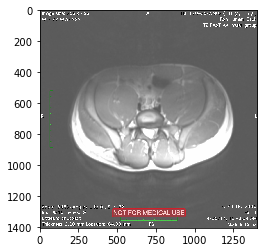

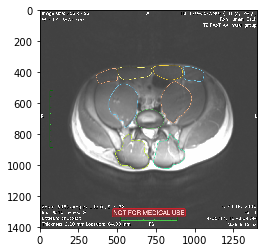

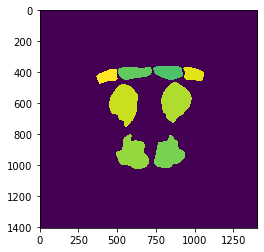

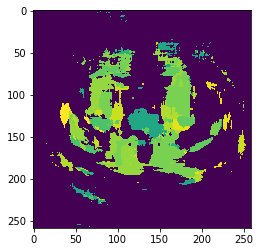

In [10]:
label = np.random.choice(list(level_01_masks.keys()))
plt.imshow(raw_images[label])
plt.show()
plt.imshow(original_images[label])
plt.show()
plt.imshow(multi_class_images[label])
plt.show()
plt.imshow(level_01_masks[label])

In [11]:
len(raw_images), len(multi_class_images), len(level_01_masks)

(310, 310, 310)

In [15]:
def clean_image(kv, shape):
    k, img = kv
    if len(img.shape) > 2:
        img = img.mean(axis=2).astype('uint8')
    cleaned_hist_img = cv2.equalizeHist(img)
    gaussian_kernel_size = tuple(((x//40)//2)*2+1 for x in cleaned_hist_img.shape)
    blurred_img = cv2.GaussianBlur(cleaned_hist_img, gaussian_kernel_size, 1)
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = zoom(blurred_img, zoom_rate)
    return k, (out-out.mean())/out.std()

def clean_mask(kv, shape, out_lim=None):
    k, img = kv
    if len(img.shape) > 2:
        img = img.sum(axis=2).astype('uint8')
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = []
    for c in sorted(np.unique(img))[1:]:
        segment = (zoom((img==c)*255, zoom_rate)>0)*c
        out.append(segment)
    if len(out) == 0:
        return k, None
    return k, np.max(np.array(out), axis=0)

In [13]:
imgTrB = bag.from_sequence(raw_images.items())
maskedTrB = bag.from_sequence(multi_class_images.items())
level01TrB = bag.from_sequence(level_01_masks.items())

In [16]:
cleaned_masks_bag = dict(maskedTrB.map(clean_mask, shape=(300, 300), out_lim={9, 11}).compute())

In [17]:
cleaned_images_bag = dict(imgTrB.map(clean_image, shape=(300, 300)).compute())#[delayed(clean_image)(x, 200) for x in imgTr.values()]

In [18]:
#cleaned_masks_bag = maskedTrB.map(clean_mask, shape=(300, 300)).compute()#[delayed(clean_image)(x, 200) for x in imgTr.values()]
cleaned_level01 = dict(level01TrB.map(clean_mask, shape=(300, 300)).compute())#[delayed(clean_image)(x, 200) for x in imgTr.values()]

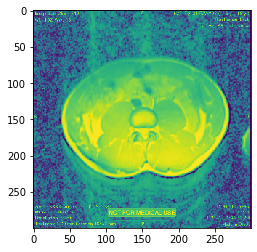

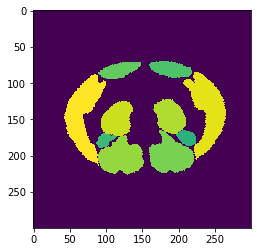

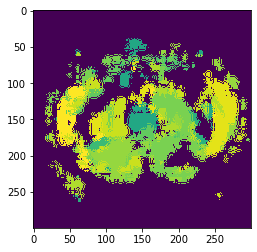

In [29]:
n = np.random.choice(list(level_01_masks.keys()))
plt.imshow(cleaned_images_bag[n])
plt.show()
plt.imshow(cleaned_masks_bag[n])
plt.show()
plt.imshow(cleaned_level01[n])

In [65]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses

In [152]:
# Keras simple deep model:
def build_v02(width, height, depth, init="he_normal"):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)

    # if we are using "channels first", update the input shape
    # and channels dimension
    # our first CONV layer will learn a total of 16 filters, each
    # Of which are 7x7 -- we'll then apply 2x2 strides to reduce
    # the spatial dimensions of the volume
    #model.add(Conv2D(32, (10, 10), strides=(1, 1), padding="same",
    #    kernel_initializer=init,# kernel_regularizer=reg,
    #    input_shape=inputShape))

    # here we stack two CONV layers on top of each other where
    # each layerswill learn a total of 32 (3x3) filters
    model.add(Conv2D(32, (10, 10), padding="same",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (5, 5), strides=(1, 1), padding="same",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    #model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Dropout(0.25))
    # stack two more CONV layers, keeping the size of each filter
    # as 3x3 but increasing to 64 total learned filters
    #model.add(Conv2D(64, (3, 3), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding="same",
        kernel_initializer=init))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    #model.add(Dropout(0.25))
#
    ## increase the number of filters again, this time to 128
    #model.add(Conv2D(128, (3, 3), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(12, (3, 3), strides=(1, 1), padding="same",
        kernel_initializer=init,  #kernel_regularizer=reg
                    )
             )
    #model.add(Conv2D(1, (3, 3), strides=(1, 1), padding="same",
    #    kernel_initializer=init, #kernel_regularizer=reg)
    #                ))
    model.add(Activation("sigmoid"))
    #model.add(BatchNormalization(axis=chanDim))
    return model

In [153]:
X1 = np.array(list(cleaned_images_bag.values()))
X2 = np.array(list(cleaned_level01.values()))
X2 = (X2 - X2.mean(axis=(1,2), keepdims=True))/X2.std(axis=(1, 2), keepdims=True)

In [154]:
X = np.concatenate([X1.reshape(*X1.shape, 1), X2.reshape(*X2.shape, 1)], axis=3)

In [155]:
Y1 = np.array(list(cleaned_masks_bag.values()))

In [156]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y1.reshape(-1, 1)).toarray().reshape(*Y1.shape, 12)

In [157]:
model = build_v02(300, 300, 1)
opt = Adam(lr=1e-4)#, decay=1e-4 / epochs)
weights = [5 for _ in range(12)]
weights[0] = 1
model.compile(loss=losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])

In [159]:
model.fit(X, Y, epochs=100, shuffle=True, batch_size=2)

Train on 310 samples
Epoch 1/100
142/310 [============>.................] - ETA: 2:02 - loss: 0.6315 - acc: 0.8742

KeyboardInterrupt: 

In [97]:
pred = model.predict(X[:1])

In [106]:
Y[:, :, :, 0].sum()/(len(Y)*300*300)

0.8758654480286738

In [89]:
X[0, :, :, 1].min()

-0.6432252895032937

In [75]:
pred_v01 = []
for x, y in zip(cleaned_images_bag, cleaned_masks_bag):
    print(x.shape)
    w, h, *_ = x.shape
    x1, y1 = sample(x, y, 41, 1)
    pred_v01.append(encoder.inverse_transform(model.predict(x1)).reshape(w-41, h-41))

(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 427)
(300, 300)
(300, 300)
(300, 300)
(300, 300)
(300, 300)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 300)
(300, 427)
(300, 427)
(300, 427)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 427)
(300, 427)
(300, 320)
(300, 300)
(300, 427)
(300, 427)
(300, 427)
(300, 427)
(300, 427)
(300, 427)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 430)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 427)
(300, 426)
(300, 300)
(300, 427)
(300, 300)
(300, 427)
(300, 427)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 300)
(300, 300)
(300, 427)
(300, 427)
(300, 300)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 426)
(300, 300)
(300, 427)
(300, 427)
(300, 427)

In [1]:
#joblib.dump(dict(zip(imgTr.keys(), pred_v01)), "data/predicted_v01.dict")
#model.save("data/04_muti_class_cnn_v03.model")

# Step 2

In [ ]:

layer_1_filter_size = 3
layer_1_filter_num = 20
layer_1_stride = 1
layer_2_filter_size = 5
layer_2_filter_num = 20
layer_2_stride = 1
layer_3_filter_num = 20
layer_3_filter_size = 7
layer_3_stride = 1
layer_3_dropout_rate = .25

n_fc1 = 128
fc1_dropout_rate = .5

n_outputs = 5
output_shape = layer_3_filter_num * \
    (neighSize-layer_1_filter_size-layer_2_filter_size-layer_3_filter_size+3)**2

tf.reset_default_graph()

print("output shape:", output_shape)

with tf.name_scope('inputs'):
    X_tf = tf.placeholder(tf.float32, [None, neighSize, neighSize, 1])
    y_tf = tf.placeholder(tf.int64, [None])
    punishment1 = tf.ones_like(y_tf)
    punishment2 = tf.ones_like(y_tf) * 10
    punishment = tf.cast(tf.where(y_tf == 0, punishment1, punishment2), tf.float32)
    training = tf.placeholder_with_default(False, shape=[], name='training')    
    
with tf.name_scope('convs'):
    conv1 = tf.layers.conv2d(X_tf, filters=layer_1_filter_num, kernel_size=layer_1_filter_size,\
                             strides=layer_1_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv1')
    conv2 = tf.layers.conv2d(X_tf, filters=layer_2_filter_num, kernel_size=layer_2_filter_size,\
                             strides=layer_2_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv2')
    conv3 = tf.layers.conv2d(X_tf, filters=layer_3_filter_num, kernel_size=layer_3_filter_size,\
                             strides=layer_3_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv3')   
with tf.name_scope('skip'):
    #skip = conv3 + X_tf
    skip = tf.concat([conv3, X_tf], axis=3)
    print(skip)
    skip_drop = tf.layers.dropout(skip, rate=layer_3_dropout_rate, training=training)
    skip_flat = tf.reshape(skip_drop, shape=[-1, neighSize*neighSize*(layer_3_filter_num+1)])

with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(skip_flat, n_fc1, activation=tf.nn.relu, name='fc1')
    fc1_drop = tf.layers.dropout(fc1, rate=fc1_dropout_rate, training=training)

with tf.name_scope('output'):
    logits = tf.layers.dense(fc1_drop, n_outputs, name='output')
    y_prob = tf.nn.softmax(logits, name='y_prob')

with tf.name_scope('training'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_tf)
    loss = tf.reduce_mean(xentropy)# * punishment)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y_tf, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()